In [4]:
# Define get links function and get all whoishiring user submissions
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
from bs4 import BeautifulSoup

ROOT_URL = "https://news.ycombinator.com/"

http = urllib3.PoolManager()
posts = []
def get_links(url, posts):
    req = http.request('GET', ROOT_URL + url)
    if req.status != 200:
        print("Error:", req.status, "skipping page", url)
        return
    page = req.data
    soup = BeautifulSoup(page, "html.parser")
    posts += soup.find_all("tr", {"class": "athing"})
    next_url = soup.find("a", {"class": "morelink"})["href"]
    return next_url, posts
next_url, posts = get_links("submitted?id=whoishiring", posts)
while next_url:
    try:
        next_url, posts = get_links(next_url, posts)
    except TypeError:
        next_url = None

In [5]:
# Get links to all Who is Hiring and Seeking Freelancer posts
hiring = []
freelance = []
for post in posts:
    title = post.find("a", {"class": "storylink"}).string
    link = post.find("a", {"class": "storylink"})["href"]
    if "who is hiring?" in title.lower():
        month = title.split("(")[1].split(")")[0]
        hiring.append({"month": month, "link": link})
    elif "freelancer?" in title.lower():
        month = title.split("(")[1].split(")")[0]
        freelance.append({"month": month, "link": link})


In [59]:
# Comment processing functions
def is_top(comment):
    td = comment.find_parent("td", {"class": "default"})
    ind = td.find_previous_sibling("td", {"class": "ind"})
    width = ind.find("img")["width"]
    if int(width) == 0:
        return True
    return False

def read_hiring_post(post):
    more = True
    data = []
    i = 1
    while(more):
        req = http.request('GET', ROOT_URL + post["link"] + "&p=" + str(i))
        if req.status != 200:
            print("Error:", req.status, "skipping page", post["month"])
            return
        page = req.data
        soup = BeautifulSoup(page, "html.parser")
        comments = soup.find_all("div", {"class": "comment"})
        for comment in comments:
            if is_top(comment):
                try:
                    data.append(str(comment.find_all("span")[0]))
                except:
                    pass
        more = soup.find("a", {"class": "morelink"})
        i += 1
    return data

def read_freelance_post(post):
    req = http.request('GET', ROOT_URL + post["link"])
    if req.status != 200:
        print("Error:", req.status, "skipping page", post["month"])
        return
    page = req.data
    soup = BeautifulSoup(page, "html.parser")
    data = {"seeking_work": [], "seeking_freelancer": []}
    comments = soup.find_all("div", {"class": "comment"})
    for comment in comments:
        if is_top(comment):
            try:
                text = str(comment.find_all("span")[0])
            except:
                text = ""
            if "seeking freelancer" in text.lower():
                data["seeking_freelancer"].append(text)
            elif "seeking work" in text.lower():
                data["seeking_work"].append(text)
    return data

In [60]:
# Process comments and write to csv
import pandas as pd
for h in hiring:
    h["comments"] = read_hiring_post(h)
for f in freelance:
    f["comments"] = read_freelance_post(f)

hiring_df = pd.DataFrame(hiring)
hiring_df.to_csv("hiring.csv")
freelance_df = pd.DataFrame(freelance)
freelance_df.to_csv("freelance.csv")

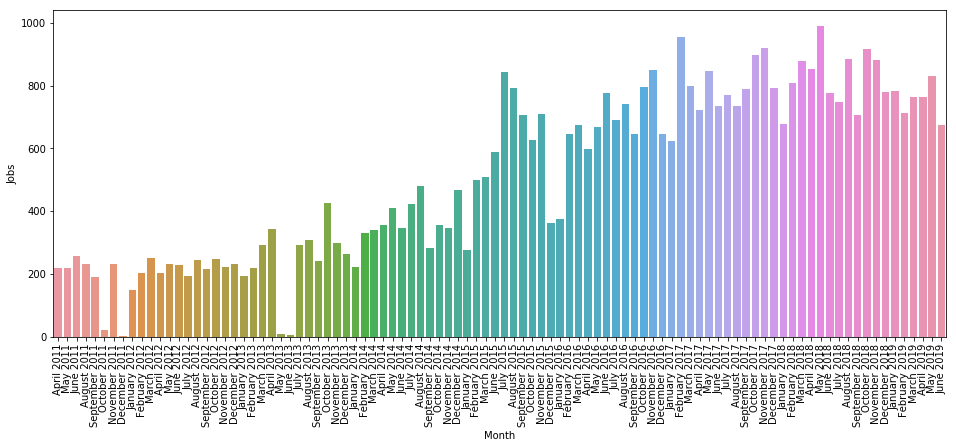

<Figure size 432x288 with 0 Axes>

In [102]:
# Make a bar chart of number of jobs posted over time
import seaborn as sns
import matplotlib.pyplot as plt

counts = []
months = []
for h in hiring:
    counts.append(len(h["comments"]))
    months.append(h["month"])
plt.figure(figsize=(16,6))
ax = sns.barplot(months, counts)
ax.set(xlabel='Month', ylabel='Jobs')
plt.xticks(rotation=90)
plt.show()

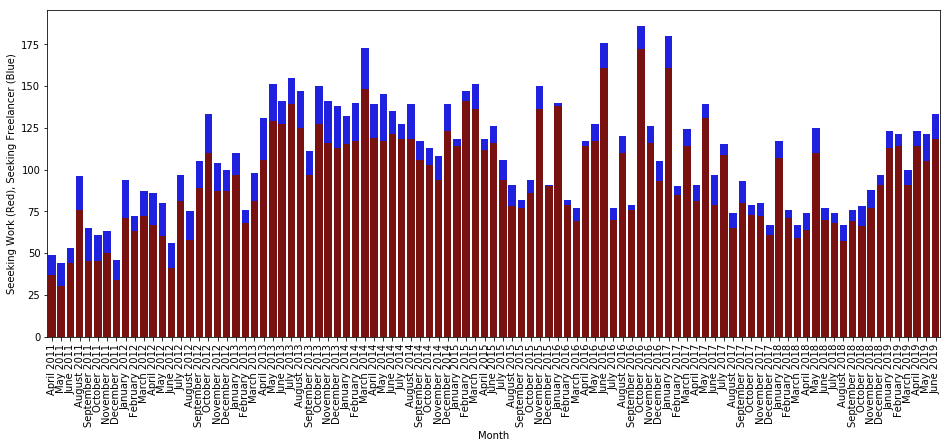

In [116]:
# Make a bar chart of number of freelancers and gigs posted over time
%matplotlib inline

total_counts = []
seeking_freelancer_counts = []
seeking_work_counts = []
months = []
freelance.reverse()
for f in freelance:
    total_counts.append(len(f["comments"]["seeking_freelancer"]) + len(f["comments"]["seeking_work"]))
    seeking_freelancer_counts.append(len(f["comments"]["seeking_freelancer"]))
    seeking_work_counts.append(len(f["comments"]["seeking_work"]))
    months.append(f["month"])
plt.figure(figsize=(16,6))
sns.barplot(months, total_counts, color="blue")
ax = sns.barplot(months, seeking_work_counts, color="darkred")
ax.set(xlabel='Month', ylabel='Seeeking Work (Red), Seeking Freelancer (Blue)')
plt.xticks(rotation=90)
plt.show()

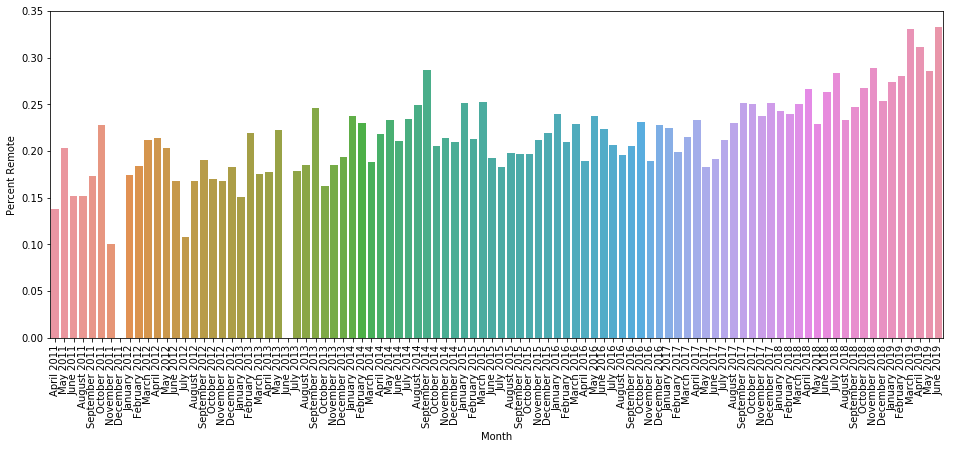

In [98]:
# Make a line chart of % of job postings with "remote" keyword
percents = []
months = []
for h in hiring:
    remote = [comment for comment in h["comments"] if "remote" in comment.lower()]
    percents.append(len(remote) / len(h["comments"]))
    months.append(h["month"])
plt.figure(figsize=(16,6))
ax = sns.barplot(months, percents)
ax.set(xlabel='Month', ylabel='Percent Remote')
plt.xticks(rotation=90)
plt.show()

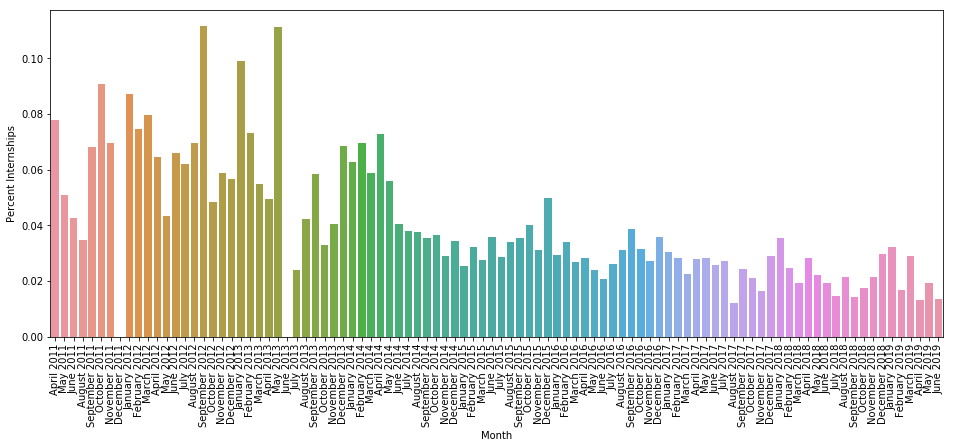

In [100]:
# Make a line chart of % of job postings with "intern" keyword
percents = []
months = []
for h in hiring:
    interns = [comment for comment in h["comments"] if "intern " in comment.lower() or "interns " in comment.lower()]
    percents.append(len(interns) / len(h["comments"]))
    months.append(h["month"])
plt.figure(figsize=(16,6))
ax = sns.barplot(months, percents)
ax.set(xlabel='Month', ylabel='Percent Internships')
plt.xticks(rotation=90)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


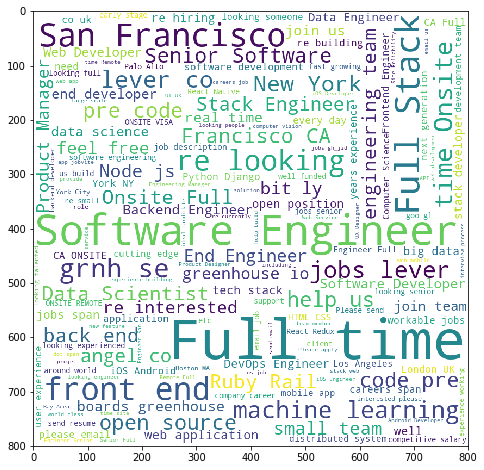

In [113]:
# Word clouds of most common words in hiring posts
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk import download
from wordcloud import WordCloud

download('stopwords')

hiring_corpus = []
for h in hiring:
    for comment in h["comments"]:
        hiring_corpus += word_tokenize(comment)
stop_words = set(stopwords.words('english') + ["<", ">", "span", "class=", "rel=", "href=", "p", "commtext", "c00", "http", "https", "nofollow"]) 
filtered_hiring_corpus = [w for w in hiring_corpus if not w in stop_words]
plt.figure(figsize=(16,8))
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(" ".join(filtered_hiring_corpus))
plt.imshow(wordcloud) 
plt.show()

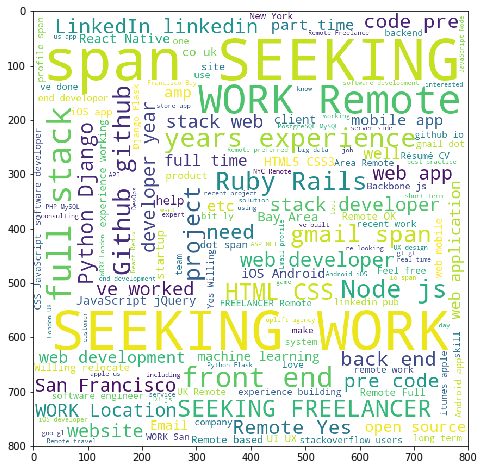

In [115]:
freelance_corpus = []
for f in freelance:
    for comment in f["comments"]["seeking_freelancer"]:
        freelance_corpus += word_tokenize(comment)
    for comment in f["comments"]["seeking_work"]:
        freelance_corpus += word_tokenize(comment)
filtered_freelance_corpus = [w for w in freelance_corpus if not w in stop_words] 
plt.figure(figsize=(16,8))
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(" ".join(filtered_freelance_corpus))
plt.imshow(wordcloud) 
plt.show()